In [16]:
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F

from pprint import pprint
import numpy as np
import torchinfo
from matplotlib import pyplot as plt
import time
import cv2
from PIL import Image
import time
from tqdm import tqdm
import torchinfo 
from pprint import pprint
from einops.layers.torch import Rearrange
import pywt

# this is same for all the code

# Dataset class implementation was done by Anshul EE20BTECH1104
# Residual block was written by Dhruv Srikanth EE20BTECH11014
# various functions like mse, mae, ssim were written by Dhruv Srikanth and Anshul Gupta
# Basic architecture of the model was taken from internet and then later modified by Utkarsh Doshi E20BTECH11052

https://github.com/AntixK/PyTorch-VAE/blob/master/models/vq_vae.py

# idea and code modified by Utkarsh Doshi EE20BTECH11052

In [17]:
from cnns_vit import CoAtNet

In [18]:
channels_img = 3
batch_size = 8
data_dir = r'C:/Users/utkar/Desktop/ivp/FFHQ64x64/'
#data_dir_new = r'C:/Users/utkar/Desktop/ML/Dataset/Celeb_dataset/500_img'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((64, 64)),
    #transforms.Normalize(())
    ])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True
)

device = 'cuda' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
!nvidia-smi

Sat Apr 29 23:54:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.52       Driver Version: 528.52       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8    15W /  95W |   5989MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# blurring was just to check how the output might look since blurring takes away the high leve feqtures


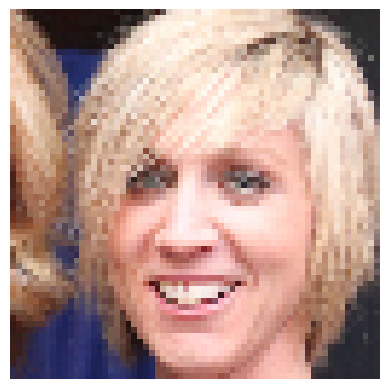

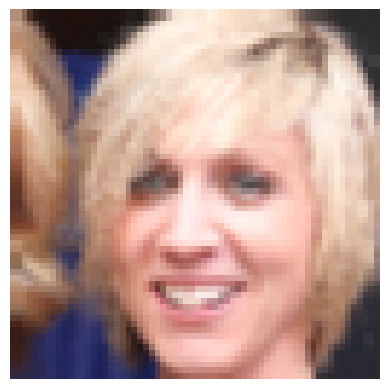

In [21]:

img = dataset[60000][0].permute(1, 2, 0)
plt.axis('off')
plt.imshow(img)
plt.show()

img_blur = torch.tensor(cv2.blur(np.array(img), (2, 2)))
plt.axis('off')
plt.imshow(img_blur)
plt.show()


In [22]:
# residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(ResidualBlock, self).__init__()
        self.ResBlock = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=2, dilation=2, bias=False),
            nn.ReLU(True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            
        )
        
    def forward(self, x):
        return x + self.ResBlock(x)
    

In [23]:
c = 16
img_size = (16, 16)
cnnvit = CoAtNet(img_size, c, 2)
pprint(torchinfo.summary(cnnvit, (1, c, img_size[0], img_size[1])))

Layer (type:depth-idx)                             Output Shape              Param #
CoAtNet                                            [1, 16, 16, 16]           --
├─Sequential: 1-1                                  [1, 16, 16, 16]           --
│    └─Transformer: 2-1                            [1, 16, 16, 16]           --
│    │    └─Sequential: 3-1                        [1, 16, 16, 16]           24,120
│    │    └─Sequential: 3-2                        [1, 16, 16, 16]           2,160
│    └─Transformer: 2-2                            [1, 16, 16, 16]           --
│    │    └─Sequential: 3-3                        [1, 16, 16, 16]           24,120
│    │    └─Sequential: 3-4                        [1, 16, 16, 16]           2,160
Total params: 52,560
Trainable params: 52,560
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.02
Forward/backward pass size (MB): 3.67
Params size (MB): 0.15
Estimated Total Size (MB): 3.84


In [24]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super(VectorQuantizer, self).__init__()
        self.K = num_embeddings
        self.D = embedding_dim
        self.beta = beta
        
        self.embedding = nn.Embedding(self.K, self.D)
        self.embedding.weight.data.uniform_(-1 / self.K, 1 / self.K)  # weight initializing
        
    def forward(self, latents):
        latents = latents.permute(0, 2, 3, 1).contiguous()  # taking dimension (channel) to right end
        latents_shape = latents.shape
        flat_latents = latents.view(-1, self.D)
        
        # computing L2 distance
        dist = torch.sum(flat_latents ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight ** 2, dim=1) - \
               2 * torch.matmul(flat_latents, self.embedding.weight.t())  # [BHW x K]
            
        # Get the encoding that has the min distance
        encoding_inds = torch.argmin(dist, dim=1).unsqueeze(1)  # [BHW, 1]
        
        # Convert to one-hot encodings
        device = latents.device
        encoding_one_hot = torch.zeros(encoding_inds.size(0), self.K, device=device)
        encoding_one_hot.scatter_(1, encoding_inds, 1)  # [BHW x K]

        # Quantize the latents
        quantized_latents = torch.matmul(encoding_one_hot, self.embedding.weight)  # [BHW, D]
        quantized_latents = quantized_latents.view(latents_shape)  # [B x H x W x D]
        
        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        embedding_loss = F.mse_loss(quantized_latents, latents.detach())
        
        vq_loss = commitment_loss * self.beta + embedding_loss

        # Add the residue back to the latents
        quantized_latents = latents + (quantized_latents - latents).detach()

        return quantized_latents.permute(0, 3, 1, 2).contiguous(), vq_loss  # [B x D x H x W]

In [25]:
# VQ-VAE
class VQVAE(nn.Module):
    def __init__(self, in_c, embedding_dim, num_embeddings, hidden_dims=None, beta=0.25, img_size=64):
        super(VQVAE, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_embedding = num_embeddings
        self.img_size = img_size
        self.beta = beta
        
        modules = []
        if hidden_dims is None:
            hidden_dims = [128, 256]
            
        i_size = img_size//2
        
        for h_dim in hidden_dims:
            #print(in_c, h_dim, i_size)
            modules.append(nn.Sequential(
                nn.Conv2d(in_c, out_channels=h_dim, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(True),
                CoAtNet((i_size, i_size), h_dim, 2),
                nn.LeakyReLU(True),
            ))
            in_c = h_dim
            i_size = i_size//2
        
        i_size = i_size*2
        #print(in_c, i_size)
        
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(),
                nn.Conv2d(in_c, in_c, kernel_size=3, stride=1, dilation=2, padding=2),
                nn.LeakyReLU(),
                CoAtNet((i_size, i_size), in_c, 2),
                nn.LeakyReLU(True),
            )
        )
        
        for _ in range(6):
            modules.append(ResidualBlock(in_c, in_c))   # see for relu
        modules.append(nn.LeakyReLU())
        
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_c, embedding_dim, kernel_size=1, stride=1),
                nn.LeakyReLU()
            )
        )
        
        self.encoder = nn.Sequential(*modules)
        
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, self.beta)
        
        # Build Decoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv2d(embedding_dim, hidden_dims[-1], kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            )
        )
        
        
        for _ in range(6):
            modules.append(ResidualBlock(hidden_dims[-1], hidden_dims[-1]))
            
        modules.append(nn.LeakyReLU())
        hidden_dims.reverse()
        
        for i in range(len(hidden_dims)-1):
            i_size = img_size//2
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i+1], kernel_size=4, stride=2, padding=1),
                    nn.LeakyReLU(),
                    CoAtNet((i_size, i_size), hidden_dims[i+1], 2),
                    nn.LeakyReLU(True),
                )
            )
            
        modules.append(
            nn.Sequential(
                # CoAtNet((32, 32), hidden_dims[-1], 2),
                # nn.LeakyReLU(True),
                nn.ConvTranspose2d(hidden_dims[-1], out_channels=3, kernel_size=4, stride=2, padding=1),
                nn.Tanh()
            )
        )
        
        self.decoder = nn.Sequential(*modules)
         
    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, z):
        z = self.decoder(z)
        return z
    
    def forward(self, x):
        encodings = self.encoder(x)
        #print(encodings.shape)
        quantized_vec, vq_loss = self.vq_layer(encodings)
        return [self.decoder(quantized_vec), x, vq_loss]
    
    def loss_f(self, *args, **kwargs):
        recons = args[0]
        inputs = args[1]
        vq_loss = args[2]
        
        recons_loss = F.mse_loss(recons, inputs)
        
        loss = recons_loss + vq_loss
        return loss, recons_loss, vq_loss
    
    def sample(self, num_samples, current_device):
        raise Warning('VQVAE sampler is not implemented.')

    def generate(self, x):
        return self.forward(x)[0]


In [26]:
# in_c, embedding_dim, num_embeddings, hidden_dims, beta=0.25, img_size=64,
vqvae = VQVAE(3, 128, 512).to(device)

In [27]:
# x = torch.rand((1, 3, 128, 128)).to('cuda')
# print(x.shape)
# encode_vec = vqvae.encoder(x)
# vqvae.vq_layer(encode_vec)[0].shape

In [28]:
pprint(torchinfo.summary(vqvae, (1, 3, 64, 64)))

Layer (type:depth-idx)                                            Output Shape              Param #
VQVAE                                                             [1, 3, 64, 64]            --
├─Sequential: 1-1                                                 [1, 128, 16, 16]          --
│    └─Sequential: 2-1                                            [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-1                                           [1, 128, 32, 32]          6,272
│    │    └─LeakyReLU: 3-2                                        [1, 128, 32, 32]          --
│    │    └─CoAtNet: 3-3                                          [1, 128, 32, 32]          590,352
│    │    └─LeakyReLU: 3-4                                        [1, 128, 32, 32]          --
│    └─Sequential: 2-2                                            [1, 256, 16, 16]          --
│    │    └─Conv2d: 3-5                                           [1, 256, 16, 16]          524,544
│    │    └─LeakyReLU: 3-6      

In [29]:
#import torch.optim.lr_scheduler as lr_scheduler

num_training_updates = 15000

# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2
# 
# embedding_dim = 64
# num_embeddings = 512
# commitment_cost = 0.25
decay = 0.99

learning_rate = 1e-4
optimizer = optim.Adam(vqvae.parameters(), lr=learning_rate)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

criterion1 = nn.MSELoss()
# criterion2 = nn.MSELoss()

(tensor(0.0065), tensor(0.0509))
tensor(0.7826)


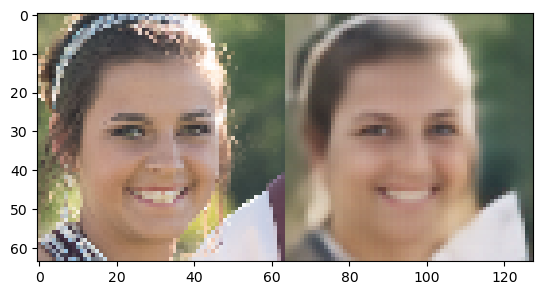

In [30]:
# def dwt_batch(images, wavelet="haar", device="cuda"):
#     with torch.no_grad():
#         batch_size, channels, height, width = images.shape
#         coeffs_list = []
#         for i in range(batch_size):
#             img = images[i].unsqueeze(0).to(device)
#             coeffs = pywt.dwt2(img.cpu().numpy(), wavelet)
#             cA, (cH, cV, cD) = coeffs
#             cA = torch.from_numpy(cA).float().unsqueeze(0).to(device)
#             cH = torch.from_numpy(cH).float().unsqueeze(0).to(device)
#             cV = torch.from_numpy(cV).float().unsqueeze(0).to(device)
#             cD = torch.from_numpy(cD).float().unsqueeze(0).to(device)
#             coeffs_list.append((cA, cH, cV, cD))
#         cA_batch = torch.cat([x[0] for x in coeffs_list], dim=0)
#         cH_batch = torch.cat([x[1] for x in coeffs_list], dim=0)
#         cV_batch = torch.cat([x[2] for x in coeffs_list], dim=0)
#         cD_batch = torch.cat([x[3] for x in coeffs_list], dim=0)
#     return cH_batch, cV_batch, cD_batch
p = r"C:\Users\utkar\Desktop\ivp\models tried\day-4\vqvae_with_hlf_day4_epoch8.pt"
vqvae = torch.load(p)


from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError

def mse(img1, img2):
    target = img1
    preds = img2
    mean_squared_error = MeanSquaredError()
    mean_s = mean_squared_error(preds, target)
    mean_absolute_error = MeanAbsoluteError()
    mean_abs = mean_absolute_error(preds, target)
    return mean_s, mean_abs
    
from torchmetrics import StructuralSimilarityIndexMeasure
import torch
def ssim(img1, img2):
    target = img1
    preds = img2
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
    return ssim(preds, target)
    
def display_func():
    with torch.no_grad():
        n = 10000
        img = torch.unsqueeze(train_loader.dataset[n][0], 0).to('cuda')
        out = vqvae(img)[0]
        
        print(mse(img.cpu(), out.cpu()))
        print(ssim(img.cpu(), out.cpu()))
        pic = np.transpose(np.concatenate((img.cpu(), out.cpu()), 3)[0], (1, 2, 0))
        plt.imshow(pic)
        plt.show()

display_func()

In [28]:


def train_vqvae(model, train_loader, optimizer, criterion1, device, epochs=10):
    model.train()
    
    train_loss = []
    recon_loss = []
    vq_loss = []
    
    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_recon_loss = 0
        epoch_vq_loss = 0
        epoch_hlf_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (data, _) in enumerate(progress_bar):
            data = data.to(device)

            optimizer.zero_grad()

            outputs = model(data)
            
            #input_hlf = dwt_batch(data)
            #output_hlf = dwt_batch(outputs[0])
            
            # hlf_loss = criterion2((output_hlf[0]+output_hlf[1]+output_hlf[2])/3 ,  (input_hlf[0]+input_hlf[1]+input_hlf[2])/3)
            sum_loss, recon_loss_batch, vq_loss_batch = model.loss_f(*outputs)
            
            loss = sum_loss #+ hlf_loss

            loss.backward()
            optimizer.step()

            #epoch_hlf_loss += hlf_loss.item()
            epoch_train_loss += loss.item()
            epoch_recon_loss += recon_loss_batch.item()
            epoch_vq_loss += vq_loss_batch.item()

            progress_bar.set_postfix({
                "Train Loss": epoch_train_loss / (batch_idx + 1),
                "Recon Loss": epoch_recon_loss / (batch_idx + 1),
                "VQ Loss": epoch_vq_loss / (batch_idx + 1),
            })
            
        #scheduler.step()
        train_loss.append(epoch_train_loss / len(train_loader))
        recon_loss.append(epoch_recon_loss / len(train_loader))
        vq_loss.append(epoch_vq_loss / len(train_loader))

        print(f"Epoch {epoch+1}: Train Loss: {train_loss[-1]:.4f}, Recon Loss: {recon_loss[-1]:.4f}, VQ Loss: {vq_loss[-1]:.4f}")
        display_func()
        if epoch % 5 == 0:
            PATH = r'C:/Users/utkar/Desktop/ivp/models tried/day-4/vqvae_with_hlf_day4_epoch' + str(epoch) + '.pt'
            torch.save(vqvae, PATH)
    return train_loss, recon_loss, vq_loss


In [29]:
train_vqvae(vqvae, train_loader, optimizer, criterion1, device, epochs=20) 

Epoch 1/20:  18%|█▊        | 1423/7752 [06:19<28:07,  3.75it/s, Train Loss=0.0153, Recon Loss=0.00582, VQ Loss=0.00943]


KeyboardInterrupt: 

In [26]:
PATH = r'C:/Users/utkar/Desktop/ivp/models tried/day-4/vqvae_with_hlf_day4_epoch8.pt'
vqvae = torch.load(PATH)